# Perryman 1998

Differences:
1.  This work will be in equitorial coordinates
2.  No projection  of center motion to candidate members since cluster is so far away at 2kpc
3.  Working only with tangental velocity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('./src')

from data_queries import  getClusterInfo, getGAIAKnownMembers
from coeval import coeval
from gaiastars import gaiastars as gs,gaiadr2xdr3

import astropy.units as u
from astropy.coordinates import SkyCoord

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
    #trumpler meta data
    trumpler_df = pd.DataFrame([
        ['Trumpler14', '10:43:55.4','-59:32:16', 2.37,0.15, 264, -6.58, 0.06, 2.185, 0.084],
        ['Trumpler15', '10:44:40.8', '-59:22:10', 2.36, 0.09, 320, np.nan, np.nan, np.nan, np.nan],
        ['Trumpler16', '10:45:10.6', '-59:42:28', 2.32,0.12, 320, -6.931,0.063, 2.612, 0.058]
    ], columns=['ClusterName','ra', 'dec','distance','disterr','radius','pm_ra_cosdec','pm_ra_cosdec_error','pm_dec','pm_dec_error']
    ).set_index('ClusterName')
    tc = SkyCoord(ra=trumpler_df.ra, dec=trumpler_df.dec,
        pm_ra_cosdec = list(trumpler_df.pm_ra_cosdec)*u.mas/u.year,
        pm_dec = list(trumpler_df.pm_dec)*u.mas/u.year,
        unit=(u.hourangle, u.deg),
        distance = list(trumpler_df.distance)*u.kpc)
    
    trumpler_coords = {}
    for i, cl in enumerate(trumpler_df.index):
        trumpler_coords[cl]=tc[i]


In [3]:
trumpler_coords['Trumpler15']

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (161.17, -59.36944444, 2.36)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (nan, nan)>

In [4]:
carina_known_members = pd.read_csv('./data/carina_members.csv', comment='#')

In [5]:
errorcolumns = [
    'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error','dr2_radial_velocity_error',
    'ra_dec_corr', 'ra_parallax_corr','ra_pmra_corr', 'ra_pmdec_corr',
    'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
    'parallax_pmra_corr', 'parallax_pmdec_corr',
    'pmra_pmdec_corr'
]
#add table to query to get the ruwe parameter
fixme = gs(name='fixme')
fixme.add_table_columns(errorcolumns)

In [6]:

carina_members={}
#for cl in cluster_names:
for cl, cluster in carina_known_members.groupby('Cluster'):
    known_members = list(cluster['Gaia Number'])
    print(f'Fetching {cl}')
    carina_members[cl]  = gs(name = cl, description=f'{cl} sources from Shull table from Gaia eDR3')
    carina_members[cl].from_source_idlist(known_members,schema='gaiaedr3', query_type='sync')

Fetching Bochum11
Fetching Other
Fetching Trumpler14
Fetching Trumpler15
Fetching Trumpler16


In [7]:
carina_members[cl].objs.columns

Index(['source_id', 'ra', 'dec', 'parallax', 'pmra', 'pmdec',
       'radial_velocity', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'ruwe', 'ra_error', 'dec_error', 'parallax_error',
       'pmra_error', 'pmdec_error', 'radial_velocity_error', 'ra_dec_corr',
       'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'r_est'],
      dtype='object')

In [8]:
#carina_cluster_names = list(carina_members.keys())
# can only deal with the Trumplers at the momemnt
carina_cluster_names = ['Trumpler14', 'Trumpler15', 'Trumpler16']

In [9]:
for cl in carina_cluster_names:

    center=trumpler_coords[cl]
    coords = carina_members[cl].get_coords()
    cen_dists = center.separation_3d(coords).to_value(u.pc)
    cen_seps = center.separation(coords).to_value(u.arcsecond)
    carina_members[cl].objs['DistanceFromCenter'] = cen_dists
    carina_members[cl].objs['SeparationFromCenter'] = cen_seps

In [10]:
print('\n--- Min/Max distance of Known Members from Cluster Center ---\n')
for cl in carina_cluster_names:
    print(f'Cluster: {cl}, Min distance: {carina_members[cl].objs.DistanceFromCenter.min():.2f} pc, Max distance: {carina_members[cl].objs.DistanceFromCenter.max():.2f} pc' )


--- Min/Max distance of Known Members from Cluster Center ---

Cluster: Trumpler14, Min distance: 11.60 pc, Max distance: 685.98 pc
Cluster: Trumpler15, Min distance: 23.14 pc, Max distance: 161.58 pc
Cluster: Trumpler16, Min distance: 3.68 pc, Max distance: 390.31 pc


In [11]:
print('\n--- Min/Max distance of Known Members from Cluster Center ---\n')
for cl in carina_cluster_names:
    print(f'Cluster: {cl}, Min Separation: {carina_members[cl].objs.SeparationFromCenter.min():.2f} as, Max Separation: {carina_members[cl].objs.SeparationFromCenter.max():.2f} as' )


--- Min/Max distance of Known Members from Cluster Center ---

Cluster: Trumpler14, Min Separation: 32.84 as, Max Separation: 322.12 as
Cluster: Trumpler15, Min Separation: 50.63 as, Max Separation: 1248.25 as
Cluster: Trumpler16, Min Separation: 43.13 as, Max Separation: 910.22 as


In [12]:
from gaiastars import from_pickle

carina_search_results = from_pickle(f'./data/carina_search_results')

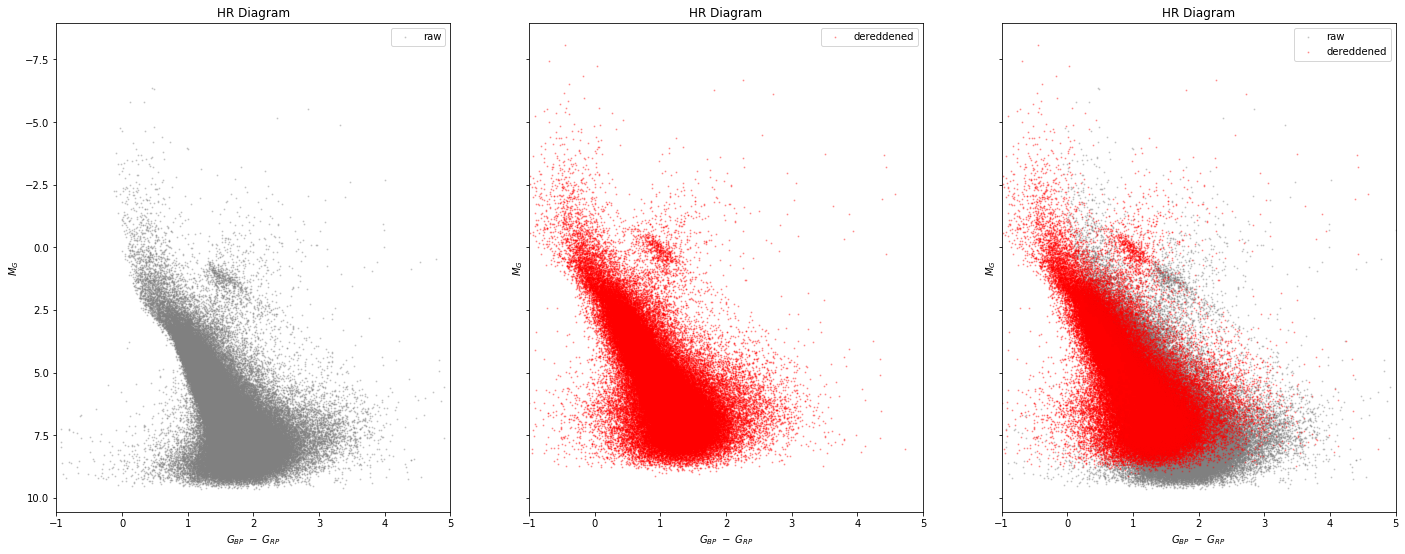

In [13]:
fig = plt.figure(figsize = (24,9))
ax = fig.subplots(1,3, sharex=True, sharey=True)
carina_search_results.plot_hrdiagram(ax=ax[0], color='grey', alpha=0.3, label='raw')
carina_search_results.plot_hrdiagram(ax=ax[1], color='red', alpha=0.3,deredden=True, label='dereddened')

carina_search_results.plot_hrdiagram(ax=ax[2], color='grey', alpha=0.3, label='raw')
carina_search_results.plot_hrdiagram(ax=ax[2], color='red', alpha=0.3,deredden=True, label='dereddened')
for a in ax:
    a.legend()

In [14]:
# compute distance relative to Trumpler 15
cl='Trumpler15'

center=trumpler_coords[cl]
coords = carina_search_results.get_coords()
cen_dists = center.separation_3d(coords).to_value(u.pc)
cen_seps = center.separation(coords).to_value(u.arcsecond)
carina_search_results.objs['DistanceFromCenter'] = cen_dists
carina_search_results.objs['SeparationCenter']= cen_seps
# known members
coords = carina_members[cl].get_coords()
cen_dists = center.separation_3d(coords).to_value(u.pc)
cen_seps = center.separation(coords).to_value(u.arcsecond)
carina_members[cl].objs['DistanceFromCenter'] = cen_dists
carina_members[cl].objs['SeparationCenter']= cen_seps


## Model Code

### Calculations
RA, Dec, PM_RA, PM_DEC calculated as unweighted mean of consitituents.

PM_RA_ERROR and PM_DEC_ERROR to be calculated as Root Means Square of the constituents' PM_RA_Error and PM_Dec_Error where:


$$
RMS(x) = \sqrt{\frac{1}{len(x)} * \sum x^2}
$$
See [Wikipedia](https://en.wikipedia.org/wiki/Root_mean_square)

In [15]:
from src.perryman import perryman

In [16]:
carina_members['Trumpler14'].objs[['pmra','pmra_error','pmdec','pmdec_error']]

,pmra,pmra_error,pmdec,pmdec_error
typed_id,,,,
5350363910256783488,-6.277307,0.019152,2.800635,0.019379
5350363910256783744,-6.618362,0.020192,2.182186,0.018905
5350363807162637696,-6.615750,0.015979,2.135090,0.016056
5350362982528878976,-6.388570,0.033582,3.010798,0.033714
5350362982543827456,-6.509177,0.028760,2.109449,0.029346
5350362982543828352,-6.889999,0.029313,1.861610,0.029560
5350383529668697472,-6.212576,0.015829,2.073719,0.015800
5350376004884719232,-6.510838,0.014819,2.025330,0.014801
5350363875896996480,-6.746614,0.013970,1.836732,0.013495


In [17]:
trumpler14=perryman(carina_members['Trumpler14'].objs,list(carina_members['Trumpler14'].objs.index))

Model initialized with 20 members; Missing members: 0
calculating velocities and errors
Tangental Velocity Shape: (20, 2, 1)
Covariance.shape: (20, 3, 3)
Tangental_velocity_error_covar.shape: (20, 2, 2)
R.shape: (20, 3, 2)
objs_dxyz.shape: (20, 3, 1)
objs_xyz.shape: (20, 3, 1)
objs_dxyz_covar.shape: (20, 3, 3)


In [22]:
trumpler14.calculate_center_motion(trumpler14.init_members)

{'d_xyz': array([[ 4.28902051],
        [81.23164872],
        [13.16951252]]),
 'd_xyz_covar': array([[ 0.14166176,  0.80688044,  0.07564954],
        [ 0.80688044, 16.53437124,  2.71324758],
        [ 0.07564954,  2.71324758,  0.47673442]]),
 'tangental_velocity': array([[-78.19850637],
        [ 25.99037062]])}

In [23]:
t14_pos, t14_motion, t14_member = trumpler14.fit0(maxiter=150, conf=0.3)

iterating


ValueError: m has more than 2 dimensions

In [24]:
t14 = perryman(carina_search_results.objs, list(carina_members['Trumpler14'].objs.index))

Model initialized with 16 members; Missing members: 4
calculating velocities and errors
Tangental Velocity Shape: (107081, 2, 1)
Covariance.shape: (107081, 3, 3)
Tangental_velocity_error_covar.shape: (107081, 2, 2)
R.shape: (107081, 3, 2)
objs_dxyz.shape: (107081, 3, 1)
objs_xyz.shape: (107081, 3, 1)
objs_dxyz_covar.shape: (107081, 3, 3)


In [25]:
pos=t14.calculate_center_pos(t14.init_members)
pos

{'xyz': array([[-1160.19394353],
        [  399.86826124],
        [-2087.67081772]]),
 'eq_coords': {'distance': array([2421.63458352]),
  'ra': array([160.98316064]),
  'dec': array([-59.55224434])},
 'R': array([[-0.32584603, -0.81504109],
        [-0.94542285,  0.28090912],
        [ 0.        ,  0.50675249]])}

In [26]:
t14.calculate_center_motion(t14.init_members)

{'d_xyz': array([[ 4.25589181],
        [78.31651843],
        [12.63583417]]),
 'd_xyz_covar': array([[ 0.09149865,  0.59232762,  0.06246806],
        [ 0.59232762, 10.24057959,  1.63051724],
        [ 0.06246806,  1.63051724,  0.277331  ]]),
 'tangental_velocity': array([[-75.42919268],
        [ 24.93505576]])}

In [27]:
t14_pos, t14_motion, t14_member = t14.fit(maxiter=150, max_dist=50)

iterating
Iterations remaining: 43, number of members: 8166


Text(0.5, 0.98, 'Proper Motions')

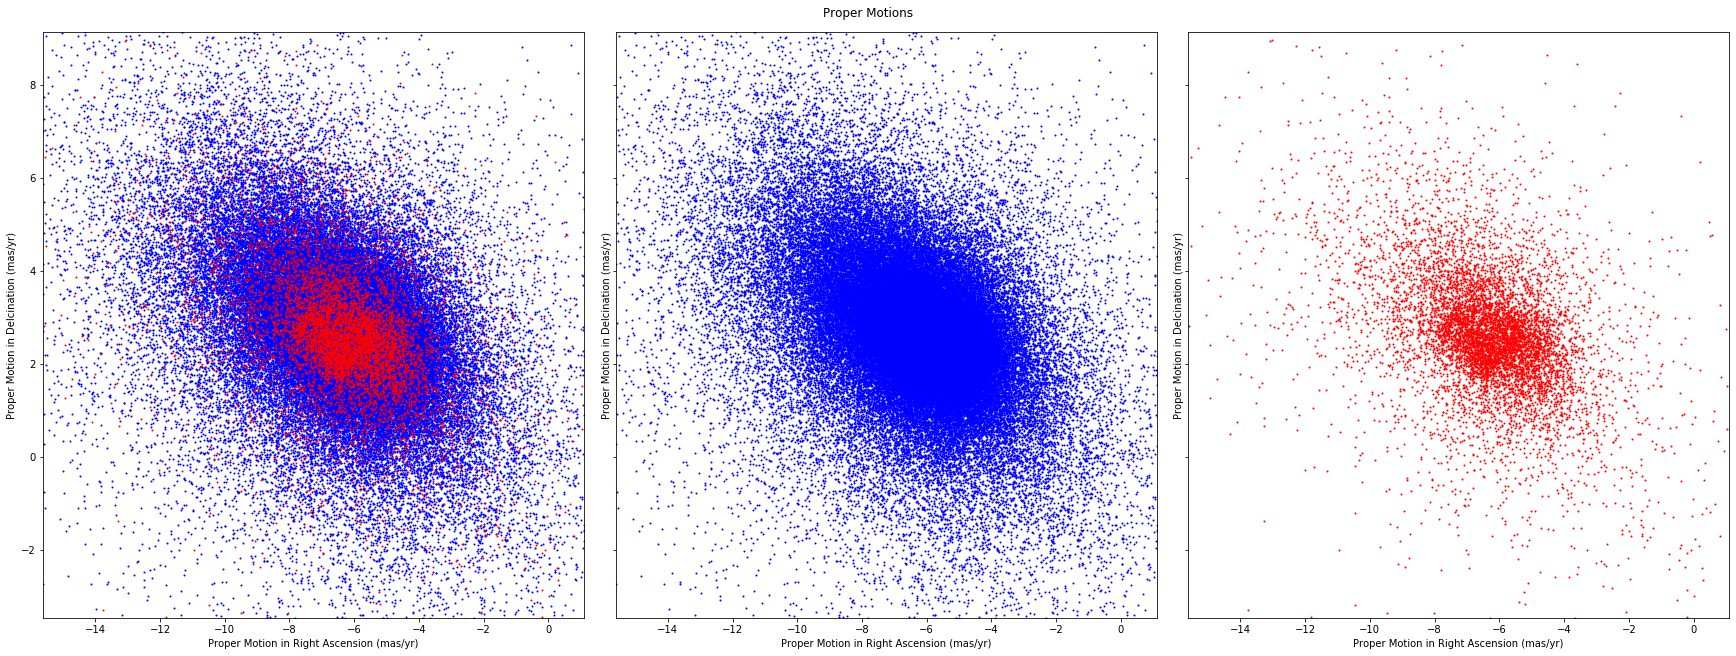

In [28]:
pm_percentile=(0,100)
pm_percentile=(0.5,99.5)

objs=t14.objs
members = t14.members
pmra_percentile = np.percentile(objs.pmra, pm_percentile)
pmdec_percentile = np.percentile(objs.pmdec, pm_percentile)

fig = plt.figure(figsize=(24,9), constrained_layout=True)
axs = fig.subplots(1,3, sharex=True, sharey=True)

axs[0].scatter(objs.pmra[~members], objs.pmdec[~members], s=1, color='blue')
axs[0].scatter(objs.pmra[members], objs.pmdec[members], s=1, color='red')

axs[1].scatter(objs.pmra[~members], objs.pmdec[~members], s=1, color='blue')
axs[2].scatter(objs.pmra[members], objs.pmdec[members], s=1, color='red')

for ax in axs:
    ax.set_xlim(pmra_percentile)
    ax.set_ylim(pmdec_percentile)
    ax.set_ylabel('Proper Motion in Delcination (mas/yr)')
    ax.set_xlabel('Proper Motion in Right Ascension (mas/yr)')
    
plt.suptitle('Proper Motions')


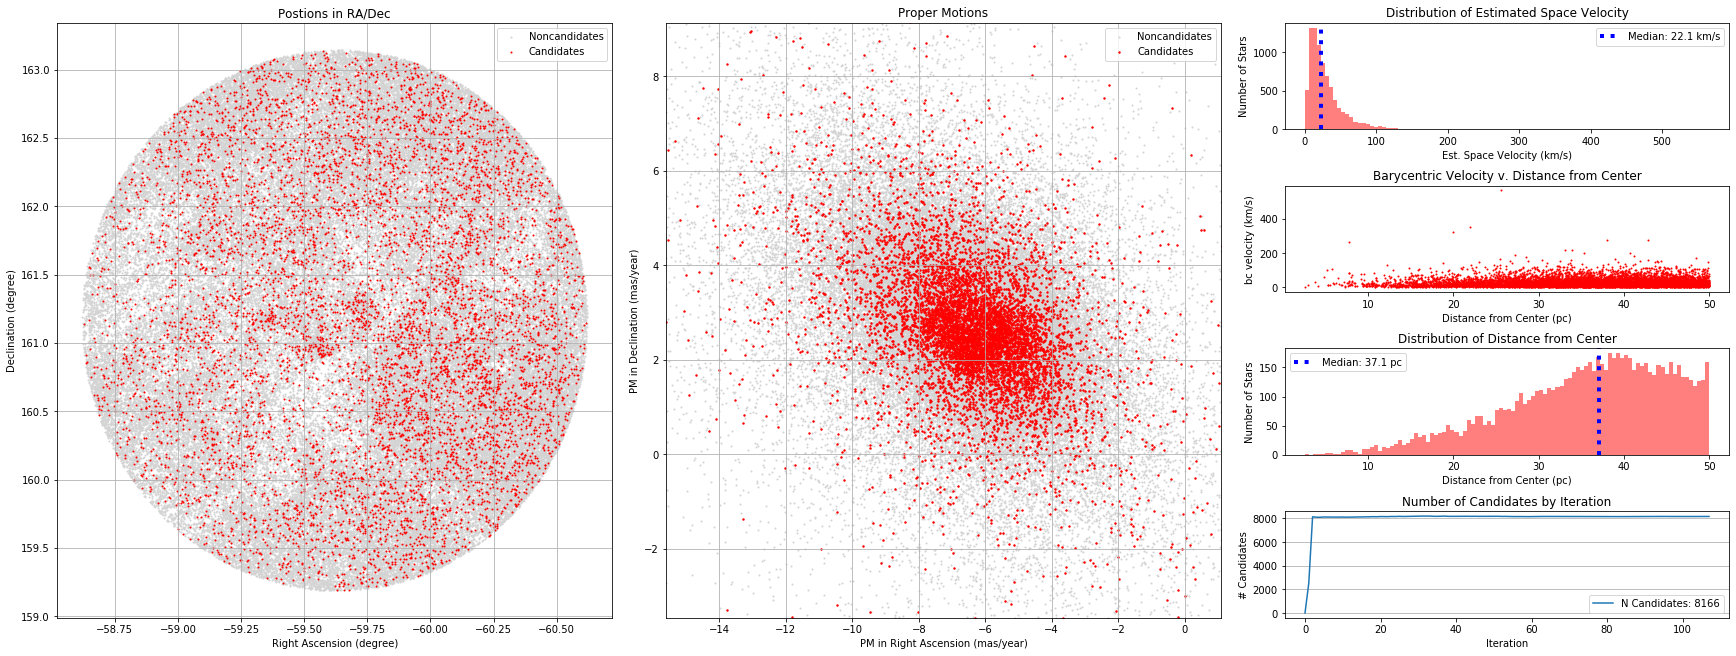

In [29]:
fig = plt.figure(figsize=(24,9), constrained_layout=True)
t14.plot(fig, pm_percentile = (0.5,99.5))

In [30]:
carina_search_results.objs['is_member']=t14.members

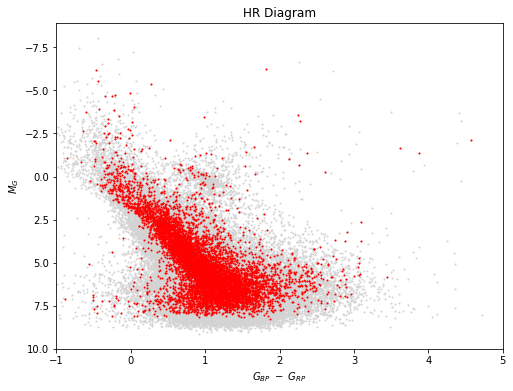

In [31]:
deredden = True
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
carina_search_results.plot_hrdiagram(ax=ax, color='lightgrey', deredden=deredden)
carina_search_results.query('is_member').plot_hrdiagram(ax=ax, color='red', deredden=deredden)
#carina_search_results.query('is_member').plot_hrdiagram(ax=ax,deredden=True, color='red')

NameError: name 't14_member2' is not defined

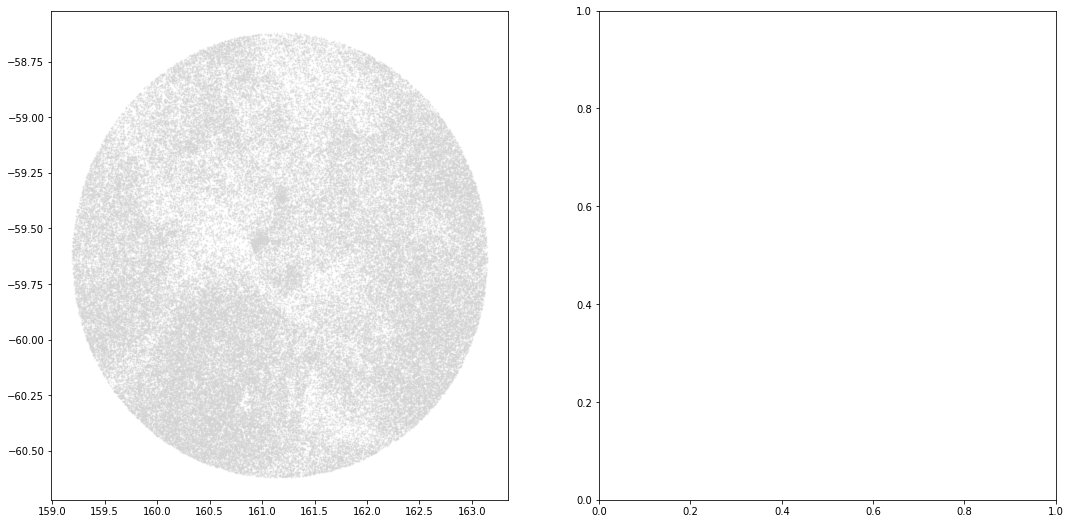

In [32]:
fig = plt.figure(figsize=(18,9))
ax = fig.subplots(1,2)

ax[0].scatter(carina_search_results.objs.ra, carina_search_results.objs.dec,color='lightgrey',s=1, alpha=0.3)
ax[0].scatter(carina_search_results.objs.ra[t14_member2], carina_search_results.objs.dec[t14_member2], color='red',s=2,alpha=0.5)
ax[0].scatter(carina_members['Trumpler14'].objs.ra,carina_members['Trumpler14'].objs.dec, color='green',s=50)

ax[0].invert_xaxis()

ax[1].scatter(carina_search_results.objs.pmra, carina_search_results.objs.pmdec, s=1, alpha=0.5)
ax[1].scatter(carina_search_results.objs.pmra[t14_member2], carina_search_results.objs.pmdec[t14_member2], color='red',s=2)
ax[1].scatter(carina_members['Trumpler14'].objs.pmra,carina_members['Trumpler14'].objs.pmdec, color='green',s=50)

In [33]:
carina_members['Trumpler14'].objs[['parallax', 'parallax_error','pmra', 'pmra_error','pmdec','pmdec_error']]

,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error
typed_id,,,,,,
5350363910256783488,0.403672,0.017538,-6.277307,0.019152,2.800635,0.019379
5350363910256783744,0.407265,0.016158,-6.618362,0.020192,2.182186,0.018905
5350363807162637696,0.425621,0.014980,-6.615750,0.015979,2.135090,0.016056
5350362982528878976,0.384546,0.032281,-6.388570,0.033582,3.010798,0.033714
5350362982543827456,0.339924,0.028105,-6.509177,0.028760,2.109449,0.029346
5350362982543828352,0.385932,0.028242,-6.889999,0.029313,1.861610,0.029560
5350383529668697472,0.434304,0.014177,-6.212576,0.015829,2.073719,0.015800
5350376004884719232,0.459950,0.013756,-6.510838,0.014819,2.025330,0.014801
5350363875896996480,0.426326,0.012670,-6.746614,0.013970,1.836732,0.013495


In [34]:
c15 = trumpler_coords['Trumpler15']
t15 = perryman(carina_search_results.objs,{'ra':c15.ra.to_value(u.degree),'dec':c15.dec.to_value(u.degree),'radius':30})


Model initialized with 21 members; Missing members: 0
calculating velocities and errors
Tangental Velocity Shape: (107081, 2, 1)
Covariance.shape: (107081, 3, 3)
Tangental_velocity_error_covar.shape: (107081, 2, 2)
R.shape: (107081, 3, 2)
objs_dxyz.shape: (107081, 3, 1)
objs_xyz.shape: (107081, 3, 1)
objs_dxyz_covar.shape: (107081, 3, 3)


In [35]:
#t14_pos2, t14_motion2, t14_member2 = t14.fit(maxiter=150, max_dist=50)
t15_pos, t15_motion, t15_members = t15.fit(maxiter=1000, max_dist=50)

iterating
Iterations remaining: 816, number of members: 8488


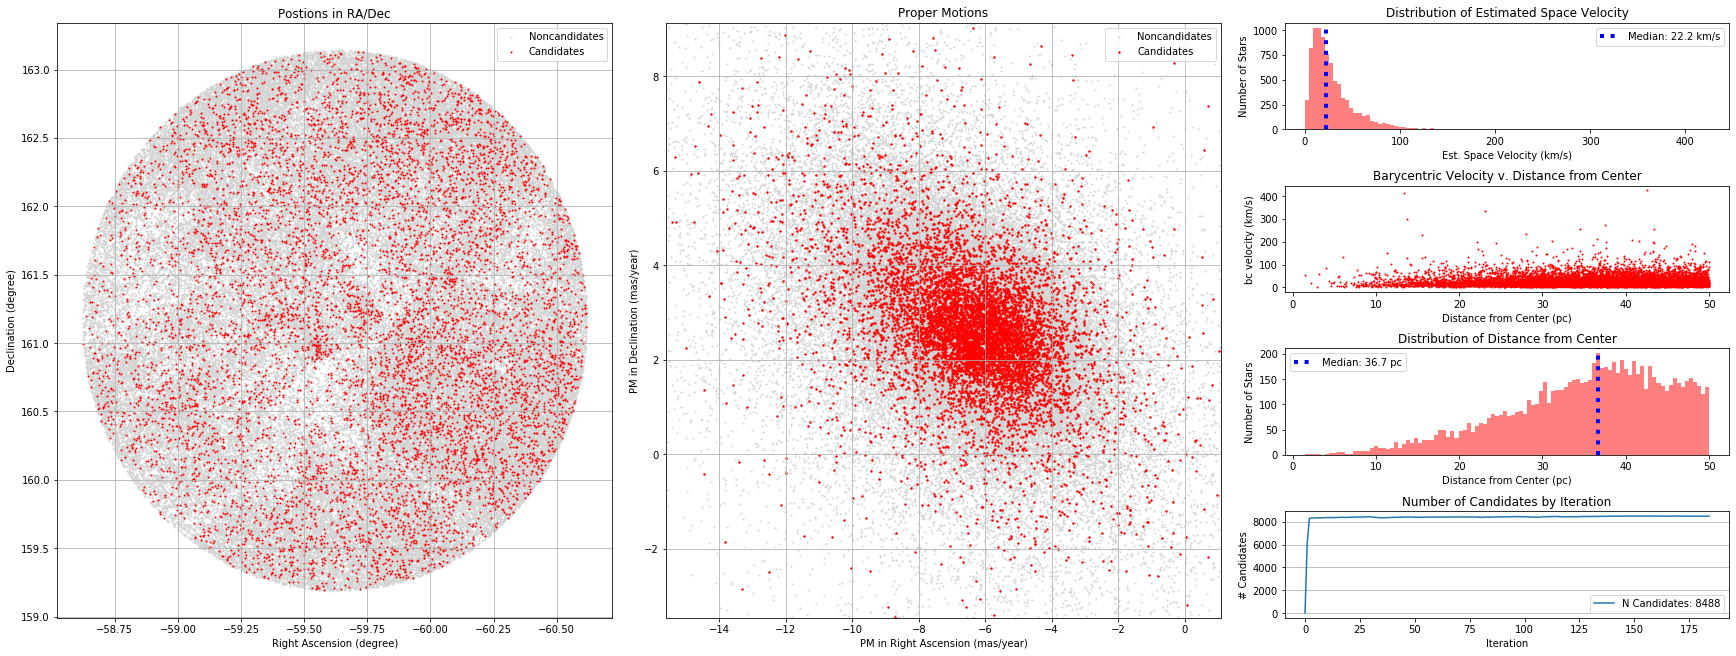

In [36]:
fig = plt.figure(figsize=(24,9), constrained_layout=True)
t15.plot(fig,pm_percentile = (0.5,99.5))

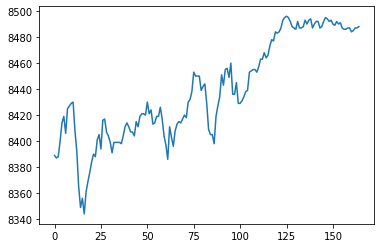

In [37]:
plt.plot(t15.nmembers_iter[20:])


(-3.456366490796243, 9.132566430470517)

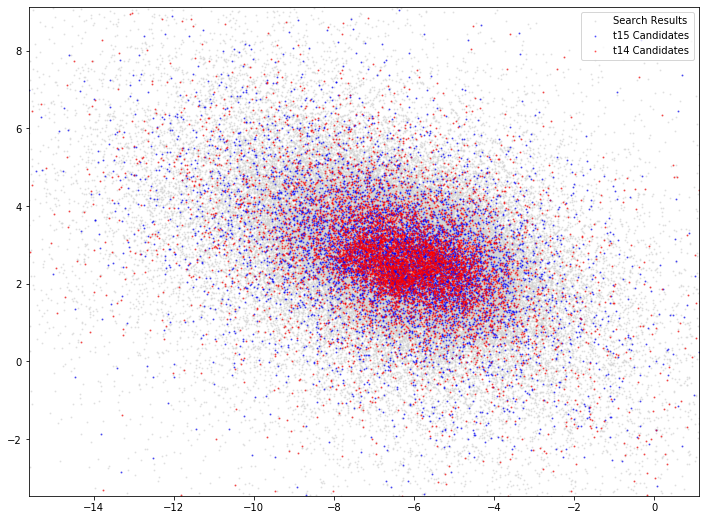

In [38]:
pm_percentile=(0,100)
pm_percentile=(0.5,99.5)
alpha=0.5
pmra_percentile = np.percentile(carina_search_results.objs.pmra, pm_percentile)
pmdec_percentile = np.percentile(carina_search_results.objs.pmdec, pm_percentile)

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot()
ax.scatter(carina_search_results.objs.pmra, carina_search_results.objs.pmdec, s=1, alpha=alpha, color='lightgrey',label='Search Results')
ax.scatter(carina_search_results.objs.pmra[t15.members], carina_search_results.objs.pmdec[t15.members], s=1,alpha=alpha, color='blue', label='t15 Candidates')
ax.scatter(carina_search_results.objs.pmra[t14.members], carina_search_results.objs.pmdec[t14.members], s=1,alpha=alpha, color='red', label='t14 Candidates')
#ax.scatter(carina_search_results.objs.pmra[t15.members], carina_search_results.objs.pmdec[t15.members], s=1,alpha=alpha, color='blue', label='t15 Candidates')
ax.legend()
ax.set_xlim(pmra_percentile)
ax.set_ylim(pmdec_percentile)

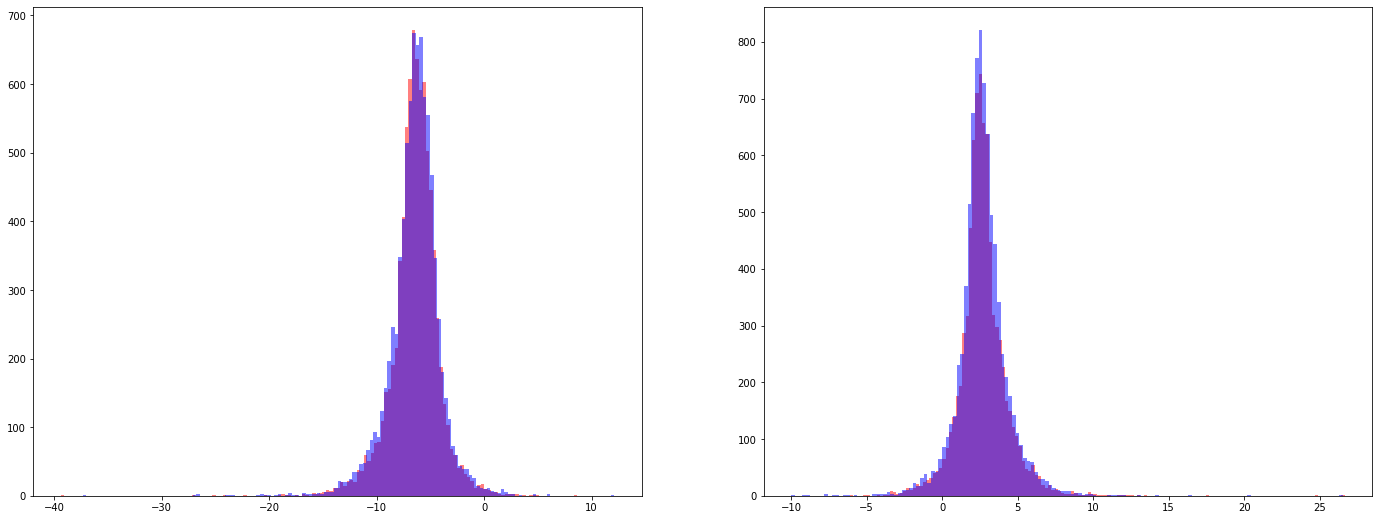

In [40]:
bins = 150
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
alpha=0.5
ax[0].hist(carina_search_results.objs.pmra[t14.members], bins = bins, color='red', alpha=alpha, label='Trumpler 14')
ax[0].hist(carina_search_results.objs.pmra[t15.members], bins = bins, color='blue', alpha=alpha, label='Trumpler 15')

ax[1].hist(carina_search_results.objs.pmdec[t14.members], bins = bins, color='red', alpha=alpha, label='Trumpler 14')
zz=ax[1].hist(carina_search_results.objs.pmdec[t15.members], bins = bins, color='blue', alpha=alpha, label='Trumpler 15')


In [41]:
np.logical_and(t14.members, t15.members).sum(), t14.members.sum(), t15.members.sum()

(25, 8166, 8488)

In [42]:
t14.center_pos

{'xyz': array([[-1144.53926165],
        [  390.08937577],
        [-2072.43799695]]),
 'eq_coords': {'distance': array([2399.40390383]),
  'ra': array([161.17952658]),
  'dec': array([-59.73804362])},
 'R': array([[-0.32260394, -0.81755019],
        [-0.94653404,  0.27864282],
        [ 0.        ,  0.50395423]])}

In [43]:
t15.center_pos

{'xyz': array([[-1098.65675213],
        [  374.90767136],
        [-1989.67224346]]),
 'eq_coords': {'distance': array([2303.56203681]),
  'ra': array([161.15821071]),
  'dec': array([-59.73882229])},
 'R': array([[-0.32295606, -0.81745295],
        [-0.94641396,  0.27894916],
        [ 0.        ,  0.50394249]])}

In [44]:
trumpler_coords['Trumpler15']

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (161.17, -59.36944444, 2.36)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (nan, nan, nan)>